In [1]:
import torch
from PIL import Image

from src.model import SiamNet, get_siamnet
from src.model import EfficientNetB3Encoder, CLIPEncoder, ViTEncoder, BarlowTwinsEncoder
from src.dataset import get_augmentations, load_config, get_coco_dataloaders, CocoDataset
from src.train import train_model

%load_ext autoreload
%autoreload 2

### Augmentations

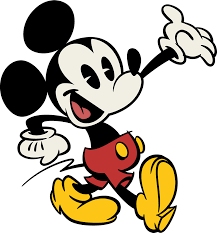

In [174]:
image = Image.open('assets/image.png').convert('RGB')
image

In [175]:
simple_transform, train_transform = get_augmentations()

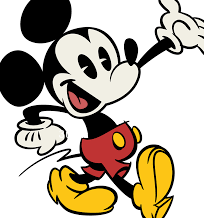

In [176]:
simple_aug = simple_transform(image)
simple_aug

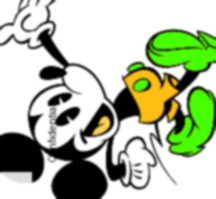

In [177]:
train_aug = train_transform(image)
train_aug

### Models

In [3]:
encoder = EfficientNetB3Encoder(freeze=True)
preprocess = encoder.preprocess
encoder.unfreeze_last_layers(3)

tensor = preprocess(image).unsqueeze(0)
print(tensor.shape, encoder(tensor).shape)

Loaded pretrained weights for efficientnet-b3
torch.Size([1, 3, 224, 224]) torch.Size([1, 1536])


In [4]:
encoder = CLIPEncoder(freeze=True)
preprocess = encoder.preprocess
encoder.unfreeze_last_layers(3)

tensor = preprocess(image).unsqueeze(0)
print(tensor.shape, encoder(tensor).shape)

torch.Size([1, 3, 224, 224]) torch.Size([1, 1024])


In [5]:
encoder = ViTEncoder(freeze=True)
preprocess = encoder.preprocess
encoder.unfreeze_last_layers(3)

tensor = preprocess(image).unsqueeze(0)
print(tensor.shape, encoder(tensor).shape)

torch.Size([1, 3, 224, 224]) torch.Size([1, 1024])


In [8]:
encoder = BarlowTwinsEncoder(freeze=True)
preprocess = encoder.preprocess
encoder.unfreeze_last_layers(3)

tensor = preprocess(image).unsqueeze(0)
print(tensor.shape, encoder(tensor).shape)

Using cache found in /home/jovyan/.cache/torch/hub/facebookresearch_barlowtwins_main


torch.Size([1, 3, 224, 224]) torch.Size([1, 2048])


In [4]:
config = load_config('configs/train_config.yaml')
net = get_siamnet(config).to('cpu')
net(tensor, tensor)

tensor([[0.4655]], grad_fn=<ViewBackward0>)

### Data

In [14]:
path = '/home/jovyan/nkiselev/ddorin/project/Pairwise-Image-Matching/data'

config_path = "configs/train_config.yaml"
train_config = load_config(config_path)

net = get_siamnet(train_config).to('cpu')
preprocessor = net.get_preprocessing()

data = CocoDataset(path, preprocessor)

Loaded pretrained weights for efficientnet-b3


In [13]:
len(data)

258624

In [14]:
dataloaders = get_coco_dataloaders(path, 
                         preprocessor, 
                         batch_size=32, 
                         num_workers=4,
                         val_size=0.1, 
                         random_seed=42)

### Testing Model

In [120]:
checkpoint_path = 'checkpoint_dir/effnet_15ep_unfreeze/checkpoint_epoch_15.pth'

config_path = "configs/train_config.yaml"
train_config = load_config(config_path)

net = get_siamnet(train_config)
preprocessor = net.get_preprocessing()

Loaded pretrained weights for efficientnet-b3


In [121]:
checkpoint = torch.load(checkpoint_path, map_location='cpu')
net.load_state_dict(checkpoint['model_state_dict'])
net.to('cpu')
net.eval()
print('ready')

ready


In [178]:
train_aug_tensor = preprocessor(train_aug.convert('RGB')).unsqueeze(0)
simple_aug_tensor = preprocessor(simple_aug.convert('RGB')).unsqueeze(0)

In [179]:
net.predict_similarity(train_aug_tensor, simple_aug_tensor).detach().numpy()

array([1.], dtype=float32)